# THE GOAL

**About VinBigData Chest X-ray Abnormalities challenge**

In this competition, you’ll automatically localize and classify 14 types of thoracic abnormalities from chest radiographs. You'll work with a dataset consisting of 18,000 scans that have been annotated by experienced radiologists. You can train your model with 15,000 independently-labeled images and will be evaluated on a test set of 3,000 images.

If we can able to build model that could accurately identify and localize findings on chest radiographs would relieve the stress of busy doctors while also providing patients with a more accurate diagnosis.

In [1]:
# Built In Imports
import os
from tqdm.auto import tqdm
import random

import numpy as np
import pandas as pd

#image handles
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
import matplotlib.patches as patches
import matplotlib.image as mpimg
import cv2
import plotly.graph_objects as go

# Dataset preparation

All images in dataset are DICOM format. So we need to convert data from DICOM to numpy array. And also images are in MONOCHROME1 formate we need to fix it.

In [2]:
# https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8) 
    return data

We found out that size of images are very large we need to fixit.

In [3]:
# Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    im = Image.fromarray(array)
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    return im

Let's convert all DICOM images into png format and resize images also

In [ ]:
'''image_id = []
dim0 = []
dim1 = []

for split in ['train', 'test']:
    load_dir = f'../input/vinbigdata-chest-xray-abnormalities-detection/{split}/'
    save_dir = f'/kaggle/tmp/{split}/'

    os.makedirs(save_dir, exist_ok=True)

    for file in tqdm(os.listdir(load_dir)):
        # set keep_ratio=True to have original aspect ratio
        xray = read_xray(load_dir + file)
        im = resize(xray, size=512, keep_ratio=True)
        im.save(save_dir + file.replace('dicom', 'png'))
        
        if split == 'train':
            image_id.append(file.replace('.dicom', ''))
            dim0.append(xray.shape[0])
            dim1.append(xray.shape[1])'''

Preprocessing x-ray image format (dicom) into normal png image format is already done by @xhlulu in the below discussion:

Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio.
Here I will just use the dataset [VinBigData Chest X-ray Resized PNG (512x512)](https://www.kaggle.com/xhlulu/vinbigdata) to skip the preprocessing and focus on modeling part.

# Files setup

In [4]:
dataset_dir = '../input/vinbigdata'

# Define the paths to the training and testing dicom folders respectively
train_dir = os.path.join(dataset_dir, "train")
test_dir =  os.path.join(dataset_dir, "test")

# get full path of images
train_full_path = [os.path.join(train_dir, f_name) for f_name in os.listdir(train_dir)]
test_full_path  = [os.path.join(test_dir, f_name) for f_name in os.listdir(test_dir)]

# get image id 
train_img_id = [os.path.splitext(f_name)[0] for f_name in os.listdir(train_dir)]
test_img_id = [os.path.splitext(f_name)[0] for f_name in os.listdir(test_dir)]

print(f"The number of training files is {len(train_full_path)}")
print(f"The number of testing files is {len(test_full_path)}")

# create img_id and img_path
train_img_id_df= pd.DataFrame(list(zip(train_img_id,train_full_path)),columns =['image_id', 'img_path'])
test_img_id_df = pd.DataFrame(list(zip(test_img_id,test_full_path)),columns =['image_id', 'img_path'])

The number of training files is 15000
The number of testing files is 3000


In [5]:
# Create the relevant dataframe objects
dataset_dir_org = '../input/vinbigdata-chest-xray-abnormalities-detection'
train_df = pd.read_csv(os.path.join(dataset_dir_org, "train.csv"))
ss_df = pd.read_csv(os.path.join(dataset_dir_org, "sample_submission.csv"))

# add img_path to data frame
train_df['img_path'] = train_df.image_id.map(train_img_id_df.set_index('image_id')['img_path'])
ss_df['img_path'] =    ss_df.image_id.map(test_img_id_df.set_index('image_id')['img_path']) 

In [6]:
train_df.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  \
0     NaN     NaN     NaN     NaN   
1     NaN     NaN     NaN     NaN   
2   691.0  1375.0  1653.0  1831.0   
3  1264.0   743.0  1611.0  1019.0   
4     NaN     NaN     NaN     NaN   

                                            img_path  
0  ../input/vinbigdata/train/50a418190bc3fb1ef163...  
1  ../input/vinbigdata/train/21a10246a5ec7af15108...  
2  ../input/vinbigdata/train/9a5094b2563a1ef3ff50...  
3  ../input/vinbigdata/train/051132a778e61a86eb14...  
4  ../input/vinbigdata/train/063319de25ce7edb9b1c...

In [7]:
train_df.shape

(67914, 9)

- we have only 15000 training images,but we have 67914 data pointes with 15 class name ,it means that some images with more than one class name and boundary boxs.

In [8]:
#get orginal images shape 
train_df_shape = pd.read_csv(os.path.join(dataset_dir, "train_meta.csv"))

Get orginal images shapes

In [9]:
df = pd.merge(train_df, train_df_shape, on="image_id")

Boundery box values are given based on orginal images shape ,we convertd orginal images into 512*512 so we will scale Boundery box with respect to resize images

In [10]:
df['x_min'] = df.apply(lambda row: (row.x_min)/row.dim1, axis =1) 
df['y_min'] = df.apply(lambda row: (row.y_min)/row.dim0, axis =1)

df['x_max'] = df.apply(lambda row: (row.x_max)/row.dim1, axis =1)
df['y_max'] = df.apply(lambda row: (row.y_max)/row.dim0, axis =1)

df['x_mid'] = df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
df['y_mid'] = df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

df['box_w'] = df.apply(lambda row: (row.x_max-row.x_min), axis =1)
df['box_h'] = df.apply(lambda row: (row.y_max-row.y_min), axis =1)

df['area'] = df['box_w']*df['box_h']
df.head()

image_id  class_name  class_id rad_id  x_min  \
0  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R11    NaN   
1  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R15    NaN   
2  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R16    NaN   
3  21a10246a5ec7af151081d0cd6d65dc9  No finding        14     R7    NaN   
4  21a10246a5ec7af151081d0cd6d65dc9  No finding        14    R13    NaN   

   y_min  x_max  y_max                                           img_path  \
0    NaN    NaN    NaN  ../input/vinbigdata/train/50a418190bc3fb1ef163...   
1    NaN    NaN    NaN  ../input/vinbigdata/train/50a418190bc3fb1ef163...   
2    NaN    NaN    NaN  ../input/vinbigdata/train/50a418190bc3fb1ef163...   
3    NaN    NaN    NaN  ../input/vinbigdata/train/21a10246a5ec7af15108...   
4    NaN    NaN    NaN  ../input/vinbigdata/train/21a10246a5ec7af15108...   

   dim0  dim1  x_mid  y_mid  box_w  box_h  area  
0  2580  2332    NaN    NaN    NaN    NaN   NaN  
1  2580  2332    NaN    NaN    NaN    NaN   NaN  
2  2580  2332    NaN    NaN    NaN    NaN   NaN  
3  3159  2954    NaN    NaN    NaN    NaN   NaN  
4  3159  2954    NaN    NaN    NaN    NaN   NaN

- image_id - unique image identifier
- class_name - the name of the class of detected object (or "No finding")
- class_id - the ID of the class of detected object
- rad_id - the ID of the radiologist that made the observation
- x_min,y_min,x_max,y_max are coordinate of the object's bounding box

# EDA

In [11]:
np.sort(df.class_name.unique().tolist())

array(['Aortic enlargement', 'Atelectasis', 'Calcification',
       'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration',
       'Lung Opacity', 'No finding', 'Nodule/Mass', 'Other lesion',
       'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis'], dtype='<U18')

We know there are 15 different possible class_names (including No finding).

[Aortic enlargement](https://www.youtube.com/watch?v=noG0A_sE-gc)
- An aneurysm is a swelling of an artery where the wall has weakened, here on the arch where the aorta, the body's main artery, exits the heart

[Atelectasis](https://www.youtube.com/watch?v=lRhdyDDZiKU)
- Complete or partial collapse of a lung or a section (lobe) of a lung.

[Calcification](https://www.youtube.com/watch?v=23pUORxBZqI)
* Calcium (calcification) may be deposited in areas where previous inflammation of the lungs or pleura has healed. 
* Many diseases or conditions can cause calcification on chest x-ray. 
* Calcification may occur in the Aorta (as with atherosclerosis) or it may occur in mediastinal lymph nodes (as with previous infection, tuberculosis, or histoplasmosis).

[Cardiomegaly](https://www.youtube.com/watch?v=lrxBeKouTWo)
* An enlarged heart, which is usually a sign of another condition.Cardiomegaly is usually diagnosed when the ratio of the heart's width to the width of the chest is more than 50%.
* Cardiomegaly can be caused by many conditions, including hypertension, coronary artery disease, infections, inherited disorders, and cardiomyopathies.

[Consolidation](https://www.youtube.com/watch?v=1hFh8snTnOs)
* Consolidation is a decrease in lung permeability due to infiltration of fluid, cells, or tissue replacing the air-containing spaces in the alveoli.
* Consolidation is officially referred to as air space consolidation. 
* On X-rays displaying air space consolidation, the lung field's density is increased, and pulmonary blood vessels are not seen, but black bronchi can be seen in the white background, which is called <i>"air bronchogram"</i>. Since air remains in the bronchial tubes, they do not absorb X-rays and appear black, and the black and white are reversed from normal lung fields.

[ILD(Interstitial Lung Disease)](https://www.youtube.com/watch?v=SPd2IATr-cg)
* Interstitial Lung Disease is a general term for many conditions in which the interstitial space is injured. 
* The interstitial space refers to the walls of the alveoli (air sacs in the lungs) and the space around the blood vessels and small airways.
* Chest radiographic findings include ground-glass opacities (i.e., an area of hazy opacification), linear reticular shadows, and granular shadows.

[Infiltration](https://www.youtube.com/watch?v=2PoVykdR76M)
* The infiltration of some fluid component into the alveoli causes an infiltrative shadow (Infiltration).
* It is difficult to distinguish from consolidation and, in some cases, impossible to distinguish. 

[Lung Opacity](https://www.kaggle.com/zahaviguy/what-are-lung-opacities)
* Lung opacity is a loose term with many potential interpretations/meanings. Please see this [kaggle discussion](https://www.kaggle.com/zahaviguy/what-are-lung-opacities) for more information.
* Lung opacity can often be identified as any area in the chest radiograph that is <b>more white than it should be.</b>

[Nodule/Mass](https://www.youtube.com/watch?v=qEOQEeim3iE)
* Nodules and masses are seen primarily in lung cancer, and metastasis from other parts of the body such as colon cancer and kidney cancer, tuberculosis, pulmonary mycosis, non-tuberculous mycobacterium, obsolete pneumonia, and benign tumors.
* A nodule/mass is a round shade (typically less than 3 cm in diameter – resulting in much smaller than average bounding boxes) that appears on a chest X-ray image. 

**Other lesion**
* Others include all abnormalities that do not fall into any other category. This includes bone penetrating images, fractures, subcutaneous emphysema, etc.

[Pleural effusion](https://www.youtube.com/watch?v=lf2V-y7b21E)
* Pleural effusion is the accumulation of water outside the lungs in the chest cavity. 
* The outside of the lungs is covered by a thin membrane consisting of two layers known as the pleura. Fluid accumulation between these two layers (chest-wall/parietal-pleura and the lung-tissue/visceral-pleura) is called pleural effusion.
* The findings of pleural effusion vary widely and vary depending on whether the radiograph is taken in the upright or supine position.
* The most common presentation of pleural effusion is <b>elevation of the diaphragm on one side, flattening the diaphragm, or blunting the angle between rib and diaphragm (typically more than 30 degrees)</b>

[Pleural thickening](https://www.youtube.com/watch?v=23pUORxBZqI)
* The pleura is the membrane that covers the lungs, and the change in the thickness of the pleura is called pleural thickening. 
* It is often seen in the uppermost part of the lung field (the apex of the lung).

[Pneumothorax](https://www.youtube.com/watch?v=EE9uLWDxwtc)
* A pneumothorax is a condition in which air leaks from the lungs and accumulates in the chest cavity. 
* When air leaks and accumulates in the chest, it cannot expand outward like a balloon due to the ribs' presence. Instead, the lungs are pushed by the air and become smaller. In other words, a pneumothorax is a situation where air leaks from the lungs and the lungs become smaller (collapsed).
* In a chest radiograph of a pneumothorax, the collapsed lung is whiter than normal, and the area where the lung is gone is uniformly black. Besides, the edges of the lung may appear linear.

[Pulmonary fibrosis](https://www.youtube.com/watch?v=_hsBFIyzwPU)
* Pulmonary Fibrosis is inflammation of the lung interstitium due to various causes, resulting in thickening and hardening of the walls, fibrosis, and scarring.
* The fibrotic areas lose their air content, which often results in dense cord shadows or granular shadows.

**No finding**
* There are no findings on x-ray images. This is the normal image and is the baseline image needed to differentiate from the abnormal image.

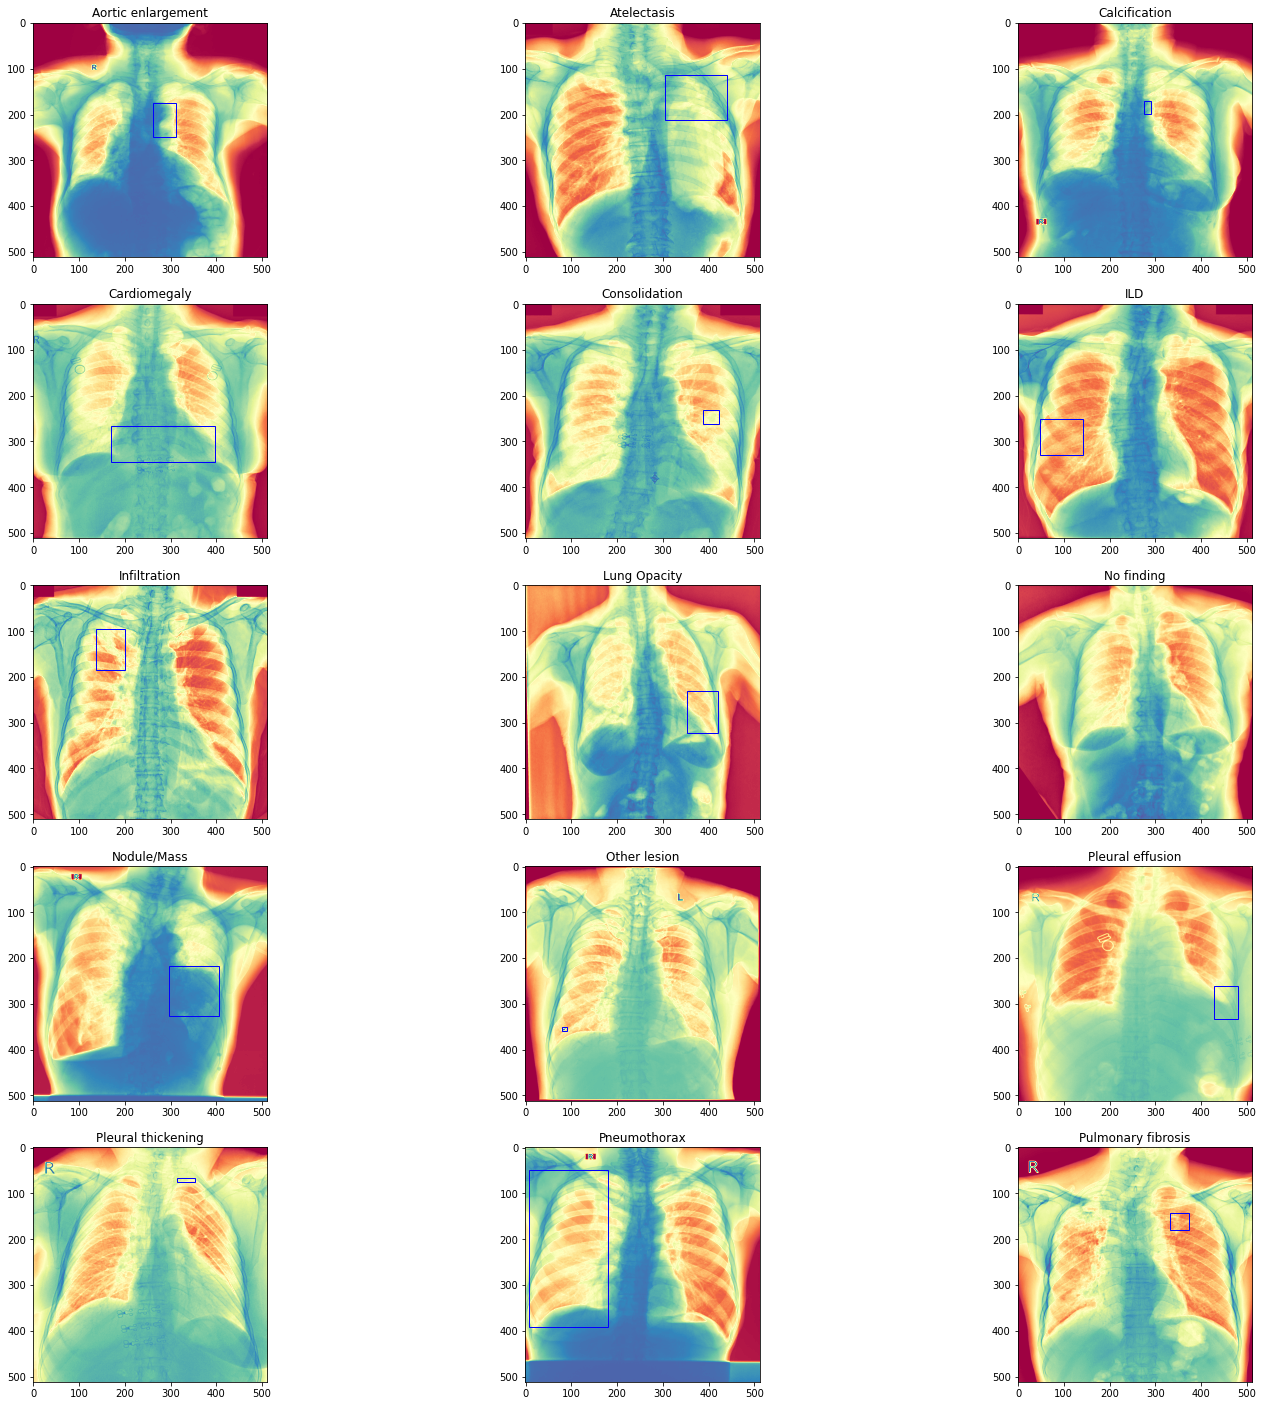

In [12]:
#https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
columns = 3
rows = 5
fig = plt.figure(figsize=(25,25))
#fig.subplots_adjust(hspace = .2, wspace=.2)
ax = []
for i, j in enumerate(np.sort(df.class_name.unique().tolist())):
    ttrain = df[df['class_name'] == j]
    indx =random.randint(0, len(ttrain))
    path = ttrain.img_path.iloc[indx]
    img = mpimg.imread(path)
    size_img = img.shape[0]
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns,i+1))
    ax[-1].set_title(str(j))  # set title
    ax[-1].add_patch(patches.Rectangle(
                (ttrain.x_min.iloc[indx]*size_img,ttrain.y_min.iloc[indx]*size_img), 
                ttrain.x_max.iloc[indx]*size_img - ttrain.x_min.iloc[indx]*size_img, 
                ttrain.y_max.iloc[indx]*size_img - ttrain.y_min.iloc[indx]*size_img, 
                edgecolor='blue', 
                fill=False))
    plt.imshow(img,cmap="Spectral")

by looking at this images we can tell difference between **No finding** and other class.But we can't distinguish between with in images with lung diseases . 

In [13]:
fig = px.histogram(df, x="class_name", color="class_name")

fig.update_layout(
    yaxis=dict(title_text='Count', titlefont=dict(size=20)),
    xaxis=dict(title_text='Abnormality Label Name', titlefont=dict(size=20)),
    title_text='Abnormalities Count Plot'
)
fig.show()

By looking into graph,we see class imbalance between this class.

In [15]:
fig = px.histogram(df, x="rad_id", color="rad_id",opacity=0.85,
                   labels={"rad_id":"Radiologist ID"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER RADIOLOGIST</b>",
                   ).update_xaxes(categoryorder="total descending")
fig.update_layout(legend_title="<b>RADIOLOGIST ID</b>",
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>")
fig.show()

- 3 of the radiologists (R9, R10, & R8 in that order) are responsible for the vast majority of annotations (~40-50% of all annotations)

In [17]:
# Create dictionary mappings
LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 15)]
int_2_str = {i:train_df[train_df["class_id"]==i].iloc[0]["class_name"] for i in range(15)}
str_2_int = {v:k for k,v in int_2_str.items()}
int_2_clr = {str_2_int[k]:LABEL_COLORS[i] for i,k in enumerate(sorted(str_2_int.keys()))}

fig = go.Figure()
for i in range(15):
    fig.add_trace(go.Histogram(
        x=df[df["class_id"]==i]["rad_id"],
        marker_color=int_2_clr[i],
        name=f"<b>{int_2_str[i]}</b>"))

fig.update_xaxes(categoryorder="total descending")
fig.update_layout(title="<b>DISTRIBUTION OF CLASS LABEL ANNOTATIONS BY RADIOLOGIST</b>",
                  barmode='stack',
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>")
fig.show()

- Among the other 10 radiologists, 7 of them (R1 through R7) have only ever annotated images as **No finding**
- The downside to this distribution, is that if we include this information in the model than the model will learn that 7 of the radiologists classify images as No finding 100% of the time!

In [18]:
df.query("image_id == '50a418190bc3fb1ef1633bf9678929b3'")

image_id  class_name  class_id rad_id  x_min  \
0  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R11    NaN   
1  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R15    NaN   
2  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R16    NaN   

   y_min  x_max  y_max                                           img_path  \
0    NaN    NaN    NaN  ../input/vinbigdata/train/50a418190bc3fb1ef163...   
1    NaN    NaN    NaN  ../input/vinbigdata/train/50a418190bc3fb1ef163...   
2    NaN    NaN    NaN  ../input/vinbigdata/train/50a418190bc3fb1ef163...   

   dim0  dim1  x_mid  y_mid  box_w  box_h  area  
0  2580  2332    NaN    NaN    NaN    NaN   NaN  
1  2580  2332    NaN    NaN    NaN    NaN   NaN  
2  2580  2332    NaN    NaN    NaN    NaN   NaN

**So the question arises, is there an image that the 3 radiologists' opinions differ?**

Let's check number of "No finding" annotations for each image, if the opinions are in complete agreement the number of "No finding" annotations should be 0 -> Abnormal(all radiologists does not think this is normal)" or "1 -> Normal(all radiologists think this is normal)".

In [19]:
normal_df = df.groupby("image_id")["class_id"].agg(lambda s:(s == 14).sum()).reset_index().rename({"class_id": "num_normal_annotations"}, axis=1)

In [20]:
normal_df.head() 
def change(x):
    if (x==3):
        x=1
    return x

normal_df['target'] = normal_df['num_normal_annotations'].apply(lambda x: change(x))

normal_df['img_path'] = normal_df.image_id.map(train_img_id_df.set_index('image_id')['img_path'])
normal_df.head()

image_id  num_normal_annotations  target  \
0  000434271f63a053c4128a0ba6352c7f                       3       1   
1  00053190460d56c53cc3e57321387478                       3       1   
2  0005e8e3701dfb1dd93d53e2ff537b6e                       0       0   
3  0006e0a85696f6bb578e84fafa9a5607                       3       1   
4  0007d316f756b3fa0baea2ff514ce945                       0       0   

                                            img_path  
0  ../input/vinbigdata/train/000434271f63a053c412...  
1  ../input/vinbigdata/train/00053190460d56c53cc3...  
2  ../input/vinbigdata/train/0005e8e3701dfb1dd93d...  
3  ../input/vinbigdata/train/0006e0a85696f6bb578e...  
4  ../input/vinbigdata/train/0007d316f756b3fa0bae...

We could confirm that always 3 radiologists opinions match for normal - abnormal diagnosis.

**Note:** This noticed that it does not apply for the other classes. i.e., 3 radiologists opinions sometimes do not match for the other class of thoracic abnormalities.

Text(0.5, 1.0, "The number of 'No finding' annotations in each image")

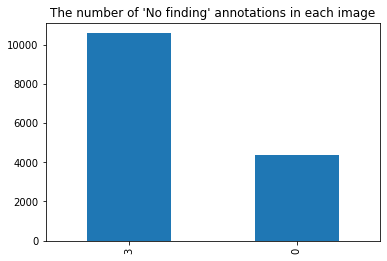

In [22]:
num_normal_counts = normal_df["num_normal_annotations"].value_counts()
num_normal_counts.plot(kind="bar")
plt.title("The number of 'No finding' annotations in each image")

So almost 70% of the data is actually "Normal" X-ray images.

Only 30% of the images need thoracic abnormality location detection.

In [23]:
# method to plot images with its annotations
def plot_all_labels(df_item, path, hide_axis = False):
    # Convert the x-ray image into RGB
    image = read_xray(path)
    # Create figure
    plt.figure(figsize = (10,10))
    plt.title("Image ID - {}".format(df_item.iloc[1]["image_id"]))
    
    for index,item in df_item.iterrows():
        
        if (np.isnan(item["x_min"]) and np.isnan(item["y_min"])):
            continue

        # Declare coordinates and convert them to integers
        x_min = int(item["x_min"]*item['dim1'])
        y_min = int(item["y_min"]*item['dim0'])
        x_max = int(item["x_max"]*item['dim1'])
        y_max = int(item["y_max"]*item['dim0'])

        # Create rectangle where the annotation is located
        image = cv2.rectangle(img=image,rec=(x_min,y_min,x_max-x_min,y_max-y_min), color = (255,0,0),thickness = 10)

        # Add label to the annotation
        image = cv2.putText(image, item["class_name"], (int(item["x_min"]*item['dim1']),int(item["y_min"]*item['dim0'])), cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(255,0,0), thickness=3)

                
    # Plot image
    plt.imshow(image)
    
    # Select if axis should be hidden
    if hide_axis:
        plt.axis("Off")
    plt.imshow(image,cmap="Spectral")

In [24]:
# Get the image ids without repetitions
image_ids = df.image_id.unique()

# Select all annotations corresponding to the first image
image_annotations = df.loc[df['image_id'].isin([image_ids[10]])]

base_path = '../input/vinbigdata-chest-xray-abnormalities-detection/train/'
path = os.path.join(base_path, "{}.dicom".format(image_annotations.image_id.iloc[0]))
image_annotations

image_id        class_name  class_id rad_id  \
72  7c1add6833d5f0102b0d3619a1682a64      Lung Opacity         7    R10   
73  7c1add6833d5f0102b0d3619a1682a64  Pleural effusion        10    R10   
74  7c1add6833d5f0102b0d3619a1682a64      Lung Opacity         7     R9   
75  7c1add6833d5f0102b0d3619a1682a64  Pleural effusion        10     R8   
76  7c1add6833d5f0102b0d3619a1682a64  Pleural effusion        10     R9   
77  7c1add6833d5f0102b0d3619a1682a64     Consolidation         4     R9   

       x_min     y_min     x_max     y_max  \
72  0.203804  0.441938  0.306726  0.505309   
73  0.121264  0.259124  0.449389  0.803251   
74  0.198709  0.429993  0.343071  0.530856   
75  0.130435  0.270073  0.452785  0.788321   
76  0.095448  0.245189  0.421875  0.756802   
77  0.198709  0.429993  0.343071  0.530856   

                                             img_path  dim0  dim1     x_mid  \
72  ../input/vinbigdata/train/7c1add6833d5f0102b0d...  3014  2944  0.255265   
73  ../input/vinbigdata/train/7c1add6833d5f0102b0d...  3014  2944  0.285326   
74  ../input/vinbigdata/train/7c1add6833d5f0102b0d...  3014  2944  0.270890   
75  ../input/vinbigdata/train/7c1add6833d5f0102b0d...  3014  2944  0.291610   
76  ../input/vinbigdata/train/7c1add6833d5f0102b0d...  3014  2944  0.258662   
77  ../input/vinbigdata/train/7c1add6833d5f0102b0d...  3014  2944  0.270890   

       y_mid     box_w     box_h      area  
72  0.473623  0.102921  0.063371  0.006522  
73  0.531188  0.328125  0.544127  0.178542  
74  0.480425  0.144361  0.100863  0.014561  
75  0.529197  0.322351  0.518248  0.167058  
76  0.500995  0.326427  0.511612  0.167004  
77  0.480425  0.144361  0.100863  0.014561

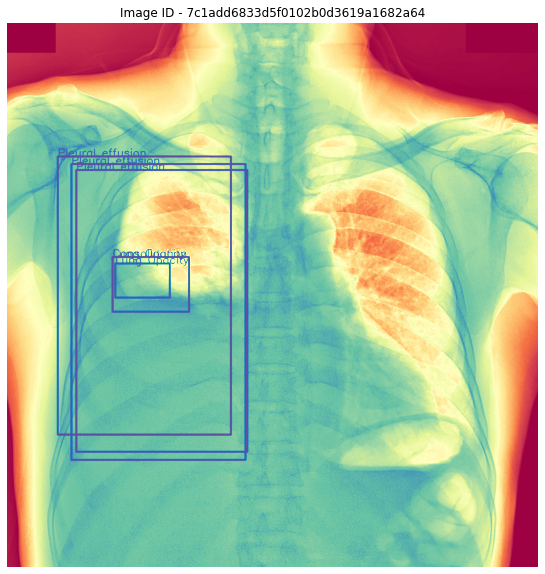

In [25]:
plot_all_labels(image_annotations, path, hide_axis = True)

Image may have diffent class, different size boundary box by different Radiologist for same image.You can see that: in each image, there are many overlapping boxes.

## t-SNE Visualization

In [26]:
df.head()

image_id  class_name  class_id rad_id  x_min  \
0  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R11    NaN   
1  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R15    NaN   
2  50a418190bc3fb1ef1633bf9678929b3  No finding        14    R16    NaN   
3  21a10246a5ec7af151081d0cd6d65dc9  No finding        14     R7    NaN   
4  21a10246a5ec7af151081d0cd6d65dc9  No finding        14    R13    NaN   

   y_min  x_max  y_max                                           img_path  \
0    NaN    NaN    NaN  ../input/vinbigdata/train/50a418190bc3fb1ef163...   
1    NaN    NaN    NaN  ../input/vinbigdata/train/50a418190bc3fb1ef163...   
2    NaN    NaN    NaN  ../input/vinbigdata/train/50a418190bc3fb1ef163...   
3    NaN    NaN    NaN  ../input/vinbigdata/train/21a10246a5ec7af15108...   
4    NaN    NaN    NaN  ../input/vinbigdata/train/21a10246a5ec7af15108...   

   dim0  dim1  x_mid  y_mid  box_w  box_h  area  
0  2580  2332    NaN    NaN    NaN    NaN   NaN  
1  2580  2332    NaN    NaN    NaN    NaN   NaN  
2  2580  2332    NaN    NaN    NaN    NaN   NaN  
3  3159  2954    NaN    NaN    NaN    NaN   NaN  
4  3159  2954    NaN    NaN    NaN    NaN   NaN

In [37]:
df_train = df[df.class_id!=14]

In [40]:
df_train = df[df.class_id!=14]
x_data = df_train[['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'box_w', 'box_w', 'area']]
y_data = df_train['class_id'].loc[x_data.index]

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, perplexity = 40, random_state=1, n_iter=5000)
embs = tsne.fit_transform(x_data)

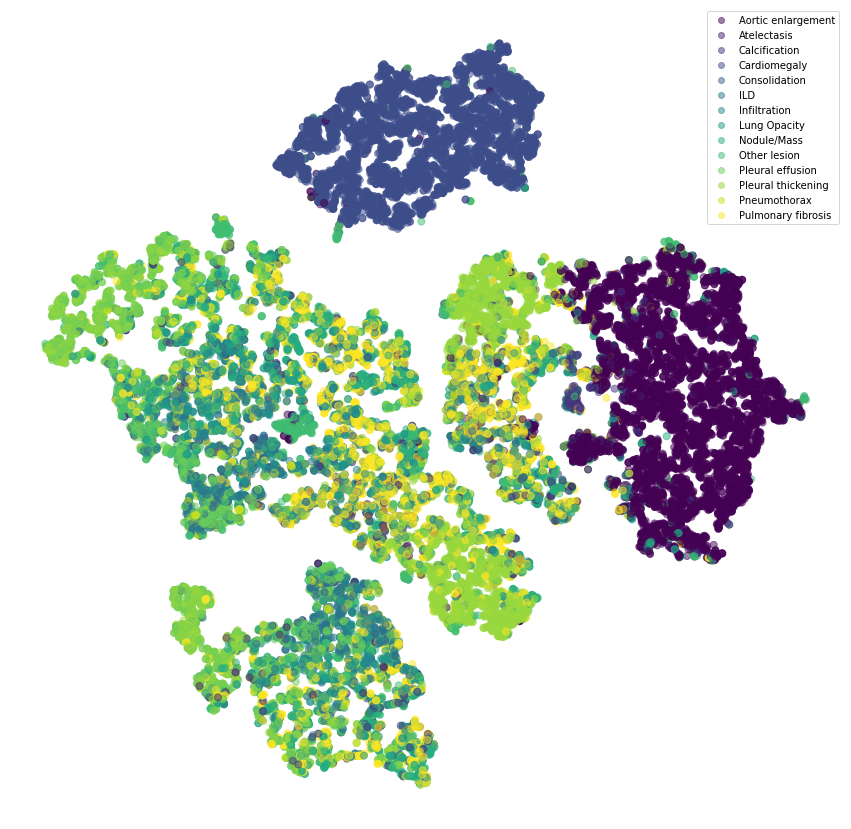

In [44]:
classes = ["Aortic enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD", "Infiltration", "Lung Opacity",
           "Nodule/Mass", "Other lesion", "Pleural effusion", "Pleural thickening", "Pneumothorax", "Pulmonary fibrosis", "No finding"]


plot_x = embs[:, 0]
plot_y = embs[:, 1]

plt.figure(figsize = (15, 15))
plt.axis('off')
scatter = plt.scatter(plot_x, plot_y, marker = 'o',s = 50, c=y_data.tolist(), alpha= 0.5,cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

we understander that boundary box are overlapping for images,we are not able to separate between class with using t-SNE also.

In [49]:
data = normal_df[['target','img_path']]
data.to_csv('classfication.csv', index=False)
data.head()

target                                           img_path
0       1  ../input/vinbigdata/train/000434271f63a053c412...
1       1  ../input/vinbigdata/train/00053190460d56c53cc3...
2       0  ../input/vinbigdata/train/0005e8e3701dfb1dd93d...
3       1  ../input/vinbigdata/train/0006e0a85696f6bb578e...
4       0  ../input/vinbigdata/train/0007d316f756b3fa0bae...

In [50]:
data.shape

(15000, 2)

In [51]:
data.target.value_counts()

1    10606
0     4394
Name: target, dtype: int64

we can apply classification algorithms on this images to classify images with thoracic disease and No disease on next notebook.